In [36]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,6)

# Weekly Tasks
Prepare a presentation using Panopto (PowerPoint slides with Video Narration is an acceptable alternative) addressing the following points:
What scenario were you assigned as the result of the random number exercise?

- What were your considerations in determining an appropriate investment strategy for that scenario?

- What asset allocation did you implement that you felt best supported that investment strategy?

- What assets did you invest in consistent with that asset allocation and strategy? (Assets, Price at time of investment, % of total investment)

- Present Value, Profit/Loss to date, VaR, SHARPE, VWAP, Alpha (Other metrics that you feel important in support of your strategy) for your portfolio 

What reallocation of assets would you recommend at this time (if any) and why?
Post your presentation accessible to your colleagues for comment and comment on the presentations by your colleagues.

# Variables

In [37]:
start_date = datetime(2022, 1, 1)
purchase_date = datetime(2023, 9, 11)
purchase_date_str = '2023-9-11'
end_date = datetime.now()
end_date_str = end_date.strftime("%Y-%m-%d")

alpha = 0.05
period = '5y'

# Functions

In [38]:
def alpha(portfolio_returns, benchmark_returns):
    # mean of the return
    portfolio_avg_return = np.mean(portfolio_returns)
    benchmark_avg_return = np.mean(benchmark_returns)
    
    # volatility
    portfolio_volatility = np.std(portfolio_returns)
    benchmark_volatility = np.std(benchmark_returns)
    
    # our alpha
    alpha = (portfolio_avg_return - benchmark_avg_return) / (portfolio_volatility / benchmark_volatility)
    
    return alpha


def linreg(x,y):
    x = sm.add_constant(x) # add a column of 1s to our data (for intercept)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1] # remove the constant
    return model.params[0], model.params[1]

# Load Data

## Load Variables

In [39]:
var_lst = ['SPY']
bench_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_econ_df = pd.DataFrame(bench_df)
bench_econ_df.columns = ['SPY']

benchPercent_econ_df = bench_econ_df.pct_change()[1:]
benchPercent_econ_df.reset_index(inplace=True)
benchPercent_econ_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,SPY
0,2023-09-12,-0.0055
1,2023-09-13,0.0012
2,2023-09-14,0.0086
3,2023-09-15,-0.0155
4,2023-09-18,0.0006


In [40]:
var_lst = ['FHNFX']
bench_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_int_df = pd.DataFrame(bench_df)
bench_int_df.columns = ['FHNFX']

benchPercent_int_df = bench_int_df.pct_change()[1:]
benchPercent_int_df.reset_index(inplace=True)
benchPercent_int_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,FHNFX
0,2023-09-12,0.0000
1,2023-09-13,0.0011
2,2023-09-14,-0.0022
3,2023-09-15,-0.0022
4,2023-09-18,0.0011


In [41]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w7/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })

folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class','Sub_Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)

# calculate portfilio percentage
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

folio_df

,Ticker,BondName,Class,Sub_Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000.0000",0.0120
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,"14,201.0000",500.0000,0.0060
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,"49,967.0000",750.0000,0.0090
3,C_A_S_H,Cash,Cash,Cash,"4,182,856.0000","4,183.0000",0.0501
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,250.0000",0.0270
5,FREL,Fidelity MSCI Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"115,479.0000","2,800.0000",0.0336
6,FSMD,Fidelity Small-Mid Multifactor ETF,Economically Sensitive,U.S. Equities,"120,705.0000","4,000.0000",0.0479
7,GARIX,Gotham Absolute Return Institutional,Economically Sensitive,Long/Short Equities,"25,278.0000",500.0000,0.0060
8,GCHDX,Gotham Hedged Core Institutional,Economically Sensitive,Long/Short Equities,"46,211.0000",500.0000,0.0060
9,ICBFX,Invesco Corporate Bond R6,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,"166,389.0000","1,000.0000",0.0120


In [42]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,183.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


In [43]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83433000.0

# 4. Portfolio

## 4.1 Load Pricing Time Series

In [44]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))

# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))

#Download closing prices
price_df = pdr.get_data_yahoo(ticker_lst, start=purchase_date, end=end_date)['Close']
price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
return_df.fillna(0, inplace=True)
return_df.index = pd.to_datetime(return_df.index)
print('return_df #:', len(return_df.columns))

ticker #: 35
price #: 35
[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')



price_df #: (25, 35)
return_df #: 35


## 4.2 Portfolio Returns

In [45]:
port_ret_weighted= return_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', port_ret_weighted.shape)

return_df['Portfolio'] = port_ret_weighted.sum(axis=1)
print('return_df #:', return_df.shape)

port_ret_weighted #: (25, 35)
return_df #: (25, 36)


In [46]:
weight_lst

array([0.01198567, 0.00599283, 0.00898925, 0.05013604, 0.02696775,
       0.03355986, 0.04794266, 0.00599283, 0.00599283, 0.01198567,
       0.06592116, 0.02397133, 0.04794266, 0.035957  , 0.04794266,
       0.04794266, 0.02996416, 0.01198567, 0.01198567, 0.01198567,
       0.05033979, 0.01198567, 0.01198567, 0.035957  , 0.01198567,
       0.07191399, 0.01198567, 0.06592116, 0.01198567, 0.02397133,
       0.035957  , 0.03895341, 0.02397133, 0.035957  , 0.01198567])

# 5. Calculate Portfolio Value

In [47]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
shares_df.head()

,Shares
Ticker,
ALTVX,"106,383.0000"
BLUEX,"14,201.0000"
BPLSX,"49,967.0000"
C_A_S_H,"4,182,856.0000"
DFAR,"108,467.0000"


In [48]:
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df.head()

,Date,Ticker,Price
0,2023-09-11,ALTVX,9.4000
1,2023-09-12,ALTVX,9.3900
2,2023-09-13,ALTVX,9.3900
3,2023-09-14,ALTVX,9.3800
4,2023-09-15,ALTVX,9.3800


In [49]:
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

l_df:  (35, 3)


In [50]:
merge_df = m_df.merge(l_df, how='outer', left_on='Ticker', right_on='Ticker').merge(shares_df,how='outer' ,left_on='Ticker', right_on='Ticker')
merge_df['share_value'] = merge_df['Price'] * merge_df['Shares']
merge_df['perc_share_value'] = merge_df.groupby(['Ticker'])[['share_value']].pct_change()

print('merge_df: ',merge_df.shape)

merge_df:  (875, 8)


In [51]:
merge_df

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,perc_share_value
0,2023-09-11,ALTVX,9.4000,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000,000.1594",NaN
1,2023-09-12,ALTVX,9.3900,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","998,936.4065",-0.0011
2,2023-09-13,ALTVX,9.3900,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","998,936.4065",0.0000
3,2023-09-14,ALTVX,9.3800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","997,872.5522",-0.0011
4,2023-09-15,ALTVX,9.3800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","997,872.5522",0.0000
...,...,...,...,...,...,...,...,...
870,2023-10-09,VTEB,47.8100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","972,120.7579",0.0061
871,2023-10-10,VTEB,47.8600,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","973,137.3924",0.0010
872,2023-10-11,VTEB,48.2100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","980,253.9114",0.0073
873,2023-10-12,VTEB,48.1000,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","978,017.2690",-0.0023


In [52]:
folioValue_df = merge_df.groupby(['Date'])[['share_value']].sum().reset_index()
folioValue_df['pct_change'] = folioValue_df['share_value'].pct_change()

print('folioValue_df: ',folioValue_df.shape)

folioValue_df:  (25, 3)


In [53]:
fv_df = merge_df.groupby(['Date','Class'])[['share_value']].sum().reset_index()
fv_df['pct_change'] = fv_df.groupby(['Class'])[['share_value']].pct_change()

print('folioValue_df: ',fv_df.shape)

folioValue_df:  (75, 4)


## 5.1 Portfolio Value

In [54]:
folio_df

,Ticker,BondName,Class,Sub_Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000.0000",0.0120
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,"14,201.0000",500.0000,0.0060
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,"49,967.0000",750.0000,0.0090
3,C_A_S_H,Cash,Cash,Cash,"4,182,856.0000","4,183.0000",0.0501
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,250.0000",0.0270
5,FREL,Fidelity MSCI Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"115,479.0000","2,800.0000",0.0336
6,FSMD,Fidelity Small-Mid Multifactor ETF,Economically Sensitive,U.S. Equities,"120,705.0000","4,000.0000",0.0479
7,GARIX,Gotham Absolute Return Institutional,Economically Sensitive,Long/Short Equities,"25,278.0000",500.0000,0.0060
8,GCHDX,Gotham Hedged Core Institutional,Economically Sensitive,Long/Short Equities,"46,211.0000",500.0000,0.0060
9,ICBFX,Invesco Corporate Bond R6,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,"166,389.0000","1,000.0000",0.0120


In [55]:
folio_df.groupby(['Class','Sub_Class'])[['Value']].sum()

Value
Class                   Sub_Class                                    
Cash                    Cash                               4,183.0000
Economically Sensitive  Emerging Market Equities           4,000.0000
                        International Equities             8,000.0000
                        Long/Short Equities                2,250.0000
                        Private Equity                     4,200.0000
                        Publicly Traded REITs             10,800.0000
                        U.S. Equities                     21,000.0000
Interest Rate Sensitive U.S. Government Bonds             17,000.0000
                        Very-High-Quality Corporate Bonds  6,000.0000
                        Very-High-Quality Municipal Bonds  6,000.0000

In [56]:
folio_df[['Value']].sum()

Value   83,433.0000
dtype: float64

In [57]:
benchPercent_int_df

,Date,FHNFX
0,2023-09-12,0.0000
1,2023-09-13,0.0011
2,2023-09-14,-0.0022
3,2023-09-15,-0.0022
4,2023-09-18,0.0011
5,2023-09-19,-0.0022
6,2023-09-20,-0.0011
7,2023-09-21,-0.0056
8,2023-09-22,0.0034
9,2023-09-25,-0.0067


## Graph Porfolio Values

In [58]:
folioValue_df[folioValue_df['Date'] == purchase_date.strftime("%Y-%m-%d")]

,Date,share_value,pct_change
0,2023-09-11,"83,718,683.5760",NaN


In [59]:
#
m1_df = folioValue_df.merge(benchPercent_econ_df, how='outer', left_on='Date', right_on='Date')
#m1_df = m1_df.melt(id_vars=['Date'])
m1_df

,Date,share_value,pct_change,SPY
0,2023-09-11,"83,718,683.5760",NaN,NaN
1,2023-09-12,"83,597,204.6712",-0.0015,-0.0055
2,2023-09-13,"83,425,622.0770",-0.0021,0.0012
3,2023-09-14,"83,951,847.4157",0.0063,0.0086
4,2023-09-15,"83,535,984.2190",-0.0050,-0.0155
5,2023-09-18,"83,385,738.9465",-0.0018,0.0006
6,2023-09-19,"83,125,551.4857",-0.0031,-0.0021
7,2023-09-20,"82,731,603.7352",-0.0047,-0.0092
8,2023-09-21,"81,637,046.9092",-0.0132,-0.0165
9,2023-09-22,"81,608,403.5950",-0.0004,-0.0022


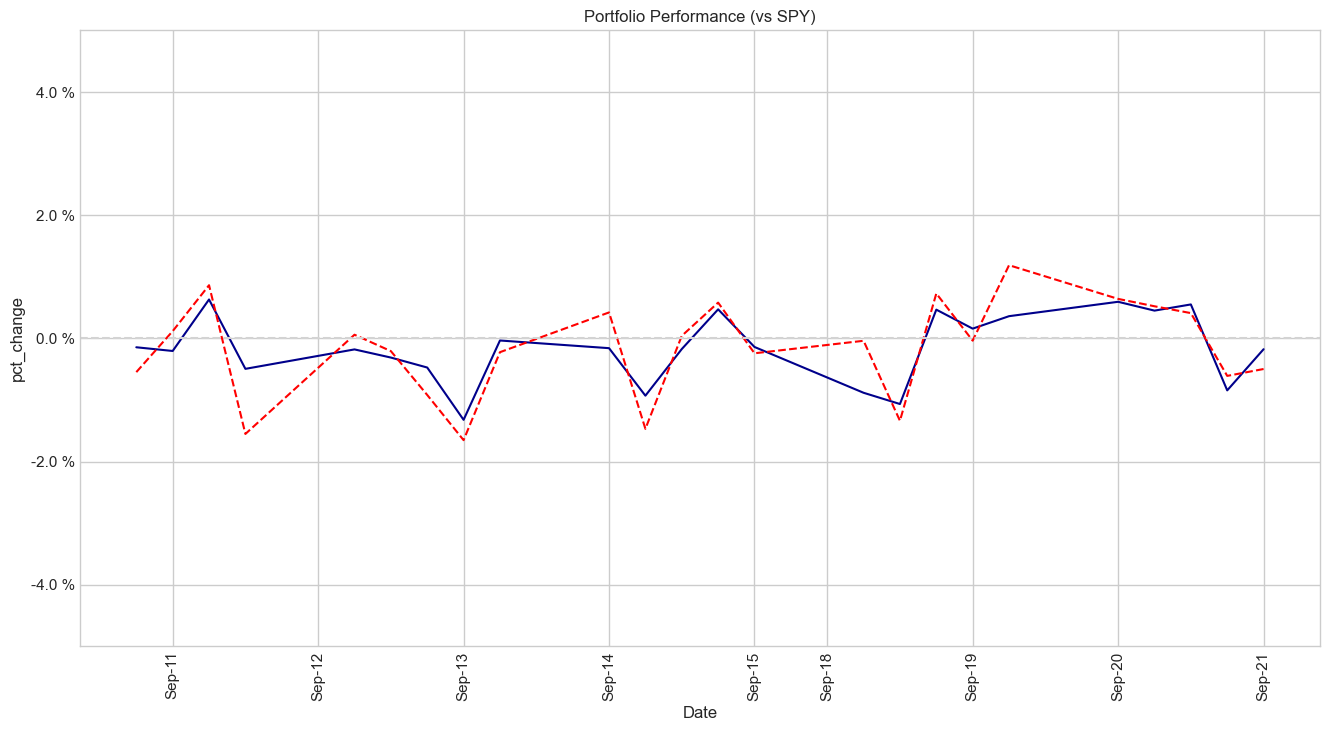

In [60]:
# Graph
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

ax.set_ylim(-.05, 0.05)
ax.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# Plot
sns.set_style("white")
g = sns.lineplot(data=m1_df, x="Date", y="pct_change", color='darkblue')
g = sns.lineplot(data=m1_df, x="Date", y="SPY", color='red', linestyle="dashed")
#ax = sns.lineplot(x=x, y=y, linestyle="dashed")
g.set_yticklabels(['{:,.1f}'.format(x) + ' %' for x in g.get_yticks() * 100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax.set(title='Portfolio Performance (vs SPY)');

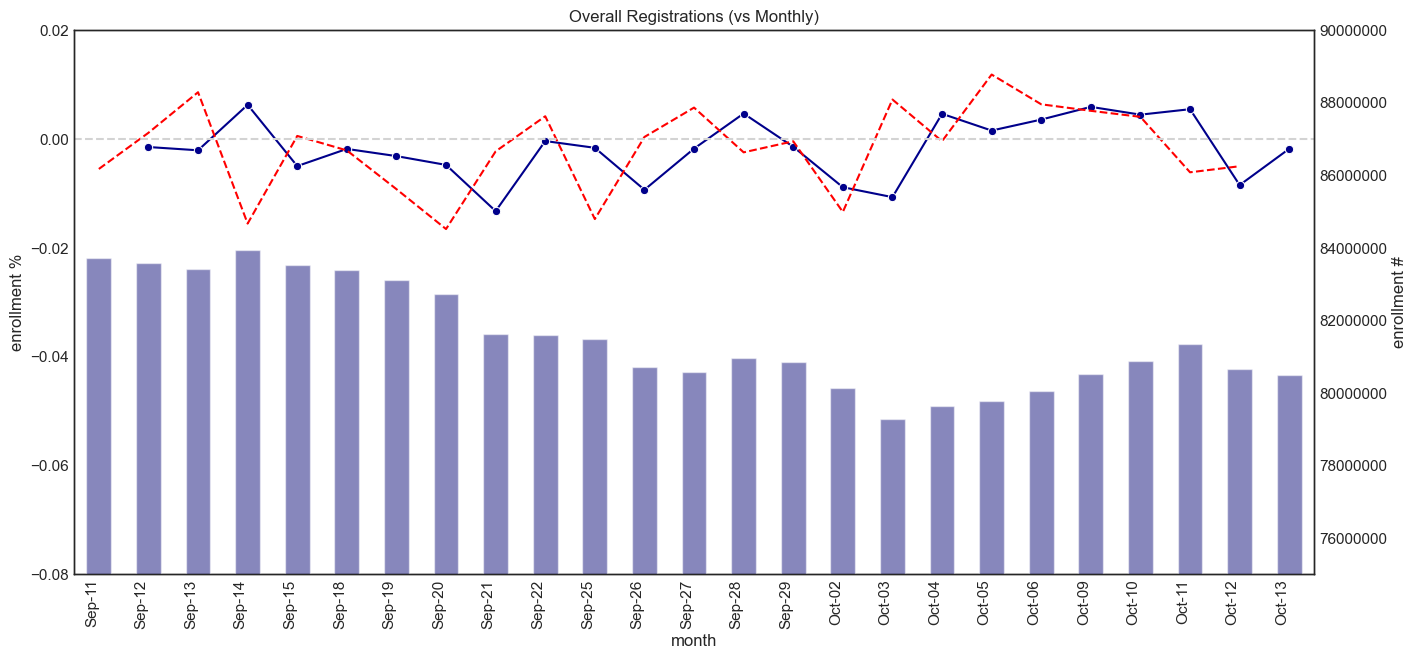

In [61]:
fig, ax1 = plt.subplots(figsize=(16,8))
sns.lineplot(data = m1_df['pct_change'], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = benchPercent_econ_df['SPY'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax2 = ax1.twinx()
sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.08, 0.02)
ax2.set_ylim(75000000, 90000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# annotations
ax1.set_title('Overall Registrations (vs Monthly)')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

In [63]:
#
m2_df = folioValue_df.merge(benchPercent_econ_df, how='outer', left_on='Date', right_on='Date')
#m1_df = m1_df.melt(id_vars=['Date'])
m2_df.head()

,Date,share_value,pct_change,SPY
0,2023-09-11,"83,718,683.5760",NaN,NaN
1,2023-09-12,"83,597,204.6712",-0.0015,-0.0055
2,2023-09-13,"83,425,622.0770",-0.0021,0.0012
3,2023-09-14,"83,951,847.4157",0.0063,0.0086
4,2023-09-15,"83,535,984.2190",-0.0050,-0.0155


In [64]:
t_df = fv_df[fv_df['Class'] == 'Economically Sensitive']
t_df.head()

,Date,Class,share_value,pct_change
1,2023-09-11,Economically Sensitive,"50,535,872.6588",NaN
4,2023-09-12,Economically Sensitive,"50,401,357.6570",-0.0027
7,2023-09-13,Economically Sensitive,"50,201,477.5737",-0.0040
10,2023-09-14,Economically Sensitive,"50,758,492.1692",0.0111
13,2023-09-15,Economically Sensitive,"50,399,819.5650",-0.0071


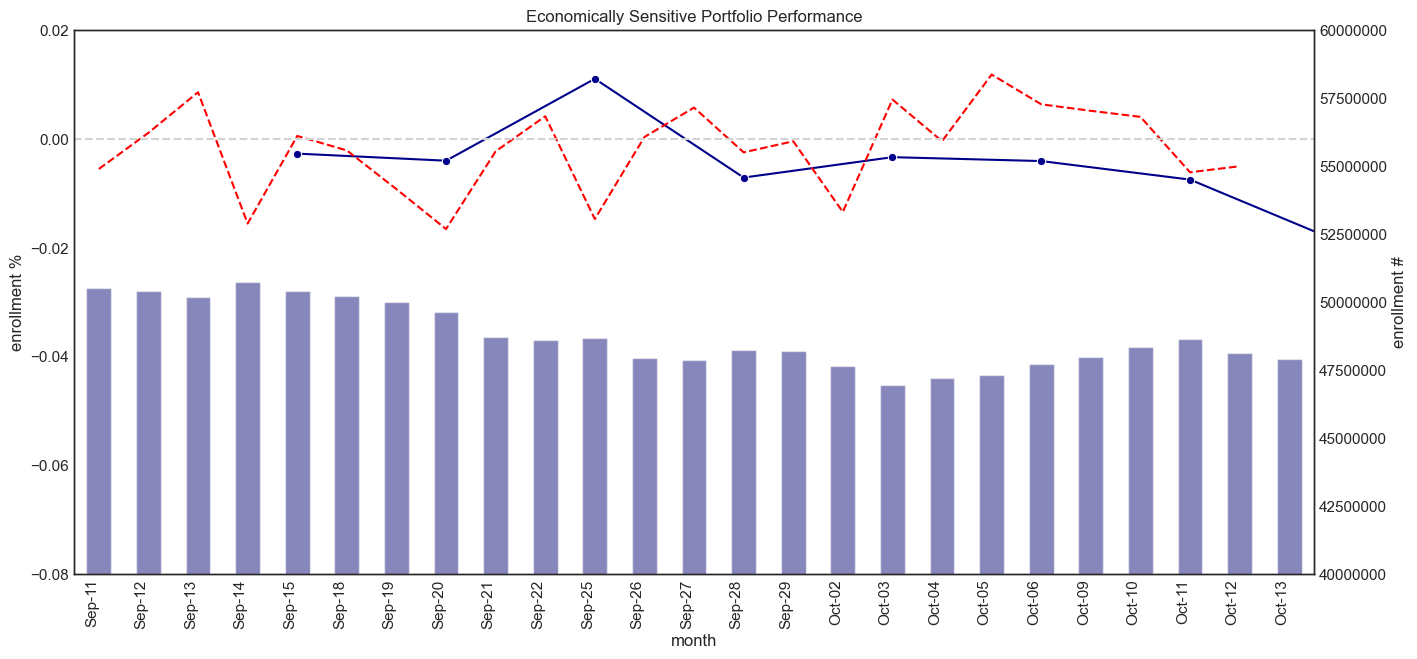

In [65]:
fig, ax1 = plt.subplots(figsize=(16,8))
sns.lineplot(data = t_df['pct_change'], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = benchPercent_econ_df['SPY'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax2 = ax1.twinx()
#sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)
sns.barplot(data = t_df, x='Date', y='share_value',errorbar=None,alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.08, 0.02)
ax2.set_ylim(40000000, 60000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# annotations
ax1.set_title('Economically Sensitive Portfolio Performance')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

In [66]:
t_df = fv_df[fv_df['Class'] == 'Interest Rate Sensitive']
t_df.head()

,Date,Class,share_value,pct_change
2,2023-09-11,Interest Rate Sensitive,"28,999,954.9171",NaN
5,2023-09-12,Interest Rate Sensitive,"29,012,991.0141",0.0004
8,2023-09-13,Interest Rate Sensitive,"29,041,288.5032",0.0010
11,2023-09-14,Interest Rate Sensitive,"29,010,499.2465",-0.0011
14,2023-09-15,Interest Rate Sensitive,"28,953,308.6540",-0.0020


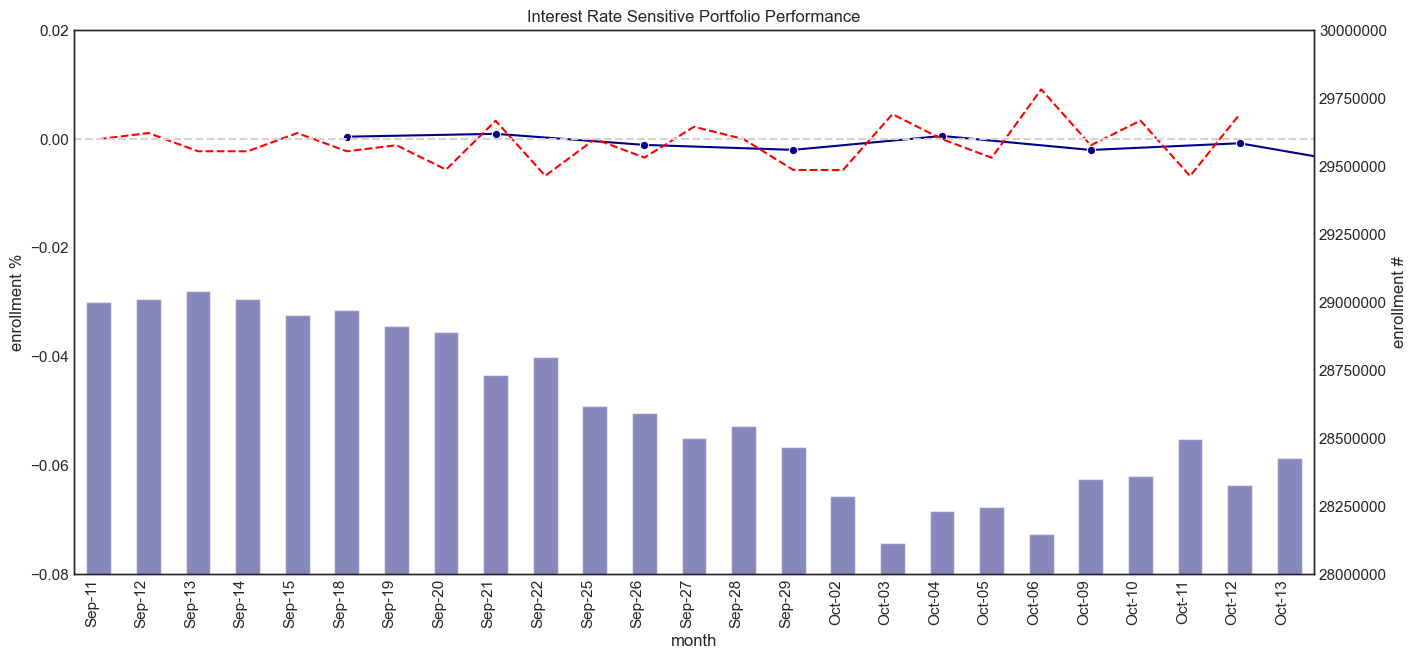

In [67]:
fig, ax1 = plt.subplots(figsize=(16,8))
sns.lineplot(data = t_df['pct_change'], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = benchPercent_int_df['FHNFX'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax2 = ax1.twinx()
#sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)
sns.barplot(data = t_df, x='Date', y='share_value',errorbar=None,alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.08, 0.02)
ax2.set_ylim(28000000, 30000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# annotations
ax1.set_title('Interest Rate Sensitive Portfolio Performance')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

# Alpha Calculations

# Economically Sensitive

In [ ]:
tickers='^DJA'
#tickers = 'FHNFX'
bench_data = pdr.get_data_yahoo(tickers=tickers, start=purchase_date, end=end_date )
bench_econ_df= pd.DataFrame(bench_data['Close'])
bench_econ_df.columns = ['bench']
bench_econ_df['precent_bench']= bench_econ_df['bench'].pct_change(1)

print('bench_econ_df:', bench_econ_df.shape)
#bench_econ_df

In [ ]:
ticker_lst = folio_econ_df['Ticker']
print('ticker_lst:', len(ticker_lst))

#value_econ_df = merge_df[merge_df['Ticker'].isin(ticker_lst)]
#print('value_econ_df:', value_econ_df.shape)

In [ ]:
bench_econ_df

In [ ]:
alpha_econ_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_econ_df['precent_bench'].values
    y = merge_df[merge_df['Ticker'] == t]['perc_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_econ_df.loc[len(alpha_econ_df.index)] = [t, alpha, beta]
    
print('alpha_econ_df:', alpha_econ_df.shape)

## Graph

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Alpha Backtest (5 year)');

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
g = sns.barplot(x='Value', y='Ticker', color='red', data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Beta Backtest (5 year)');

# Interest Rate Sensitive

In [ ]:
#tickers='^DJA'
tickers = 'FHNFX'
bench_data = pdr.get_data_yahoo(tickers=tickers, start=purchase_date, end=end_date )
bench_int_df= pd.DataFrame(bench_data['Close'])
bench_int_df.columns = ['bench']
bench_int_df['precent_bench']= bench_int_df['bench'].pct_change(1)

print('bench_int_df #:', bench_int_df.shape)
lb = len(bench_int_df)

In [ ]:
ticker_lst = folio_int_df['Ticker']
print('ticker_lst:', len(ticker_lst))

In [ ]:
alpha_int_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_int_df['precent_bench'].values
    y = merge_df[merge_df['Ticker'] == t][:lb]['perc_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_int_df.loc[len(alpha_int_df.index)] = [t, alpha, beta]
    
print('alpha_int_df:', alpha_int_df.shape)

## Graph

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Alpha Backtest (5 year)');

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
g = sns.barplot(x='Value', y='Ticker', color='red',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Beta Backtest (5 year)');